First import the following libraries:

In [65]:
import numpy as np
import math as m
from scipy import linalg
from scipy.sparse import diags
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

Write a function to compute $\widehat A$, $\widehat B$, $\widehat C$, $\widehat D$, and $\widehat E$ given $A$, $B$, $C$, $D$, and $E$:

In [66]:
def Interpolate(vals, s_vals):
    """
    Inputs:
        vals - Dictionary of matrices A, B, C, D, and E
        s_vals - List of the imaginary frequencies at which to train the ROM
        
    Returns a dictionary of hat matrices A, B, C, D, and E which make a ROM
    of transfer function. The ROM transfer function will equal the FOM transfer
    function at the frequencies in s_vals.
    """
    size = (np.shape(vals['A'])[0], len(s_vals))
    
    #Generate Interpolation Matrices V and W
    V_complex = np.zeros(size, dtype = 'complex')
    W_complex = np.zeros(size, dtype = 'complex')
    for s in s_vals:
        V_complex[:, s_vals.index(s)] = np.reshape(
            np.linalg.solve((s * 1j * vals['E'] - vals['A']), vals['B']), (size[0],))
        W_complex[:, s_vals.index(s)] = np.reshape(
            np.linalg.solve((s * 1j * vals['E'] - np.transpose(vals['A'])), vals['C']), (size[0],))
    
    #Convert complex matrices to real matrices
    real_matrices = []
    for X in [V_complex, W_complex]:
        result = np.zeros((X.shape[0], X.shape[1] * 2))
        result[:, :X.shape[1]] = np.real(X)
        result[:, X.shape[1]:] = np.imag(X)
        real_matrices.append(result)
        
    u_v, s_v, v_v = linalg.svd(real_matrices[0])
    u_w, s_w, v_w = linalg.svd(real_matrices[1])

    eps = np.finfo(float).eps
    i = 0
    while (s_w[i] / s_w[0] > eps or s_v[i] / s_v[0] > eps) and i < s_v.shape[0] - 1:
        i += 1
        
    print ("FOM size is: " + str(size[0]) + "\t ROM size is: " + str(i))
    
    V = u_v[:, :i]
    W = u_w[:, :i]
    
    #Calculate Hat Matrices
    A_hat = np.transpose(W) @ vals['A'] @ V
    B_hat = np.transpose(W) @ vals['B']
    C_hat = np.transpose(np.transpose(vals['C']) @ V)
    D_hat = vals['D']
    E_hat = np.transpose(W) @ vals['E'] @ V 

    return {'A' : A_hat, 'B' : B_hat, 'C' : C_hat, 'D' : D_hat, 'E' : E_hat}

Set up $A$, $B$, $C$, $D$, and $E$ for the one dimensional advection diffusion equation:

In [67]:
#Parameters

ALPHA = .01
BETA = 1
T = .5 # time interval
DELTA = .01 # delta x, positional step size
NX = int(1/DELTA) # number of increments

#Matrices

A_diff = (1. / DELTA**2) * diags([np.ones((NX - 1)), -2 * np.ones((NX)), np.ones((NX - 1))], [-1, 0, 1]).toarray()
A_conv = (1. / DELTA) * diags([np.ones((NX - 1)), -1 * np.ones((NX))], [-1, 0]).toarray()
A = ALPHA * A_diff + BETA * A_conv

B = np.zeros((NX, 1))
B[0] = ALPHA / DELTA**2 + BETA / DELTA

C = np.ones((NX , 1)) * DELTA
C[-1] = DELTA / 2

D = DELTA / 2

E = np.eye(NX)

d1_vals = {'A': A, 'B': B, 'C': C, 'D': D, 'E': E}

Set up $A$, $B$, $C$, $D$, and $E$ for the two dimensional advection diffusion equation:

In [68]:
#Parameters
ALPHA = .01
BETA = 1
T_INT = .5
n1 = 30
n2 = 30
h1 = 1.0 / n1
h2 = 1.0 / (n2 + 1)
nt = 100
delta_t = T_INT / nt

##Matrices

#Adiff
main_diag = [-2 for dummy in range(n1)]
lower_diag = [1 for dummy in range(n1-1)]
upper_diag = [1 for dummy in range(n1-1)]

a1 = diags([main_diag,lower_diag,upper_diag],[0,-1,1]).toarray() * (1.0 / h1 ** 2)
a1[-1, -2] = 2.0 / h1 ** 2
a2 = diags([main_diag,lower_diag,upper_diag],[0,-1,1]).toarray() * (1.0 / h2 ** 2)

#Aconv
main_diag = [-1 for dummy in range(n1)]
Aconv = diags([main_diag,lower_diag],[0,-1]).toarray()

#Generate A
I1 = np.eye(n1)
I2 = np.eye(n2)
A = np.kron(I2, (ALPHA * a1) + (BETA * Aconv)) + np.kron(ALPHA * a2, I1)

#Generate B
e = np.zeros((n1,1))
e[0] = (ALPHA / (h1**2)) + (BETA / h1)
B = np.kron(I2, e)
e = np.ones((n2,1))
B = B @ e

#Generate C
c1 = h2 * np.ones((n2,1))
c2 = h1 * np.ones((n1,1))
c2[-1] = c2[-1] * .5
C = np.kron(c1, c2)

#Gerenate D
D = (h1*h2*.5)*np.ones((n2,))
D = D @ e

#Generate E
E = np.eye(n1*n2)

d2_vals = {'A': A, 'B': B, 'C': C, 'D': D, 'E': E}

Select $r$ imaginary training frequencies logarithmically spaced between $10^{-3}$ and $10^3$, and compute the hat matrices for the one and two dimensional cases:

In [69]:
r = int(input("Enter value for r: "))

s_vals = np.logspace(-3, 3, r).tolist()
d1_hat_vals = Interpolate(d1_vals, s_vals)
d2_hat_vals = Interpolate(d2_vals, s_vals)

Enter value for r: 6
FOM size is: 100	 ROM size is: 11
FOM size is: 900	 ROM size is: 11


Write a function to compare the transfer functions of the FOM and the ROM. Use this function to illustrate the accuracy of one dimensional ROM and the two dimensional ROM:

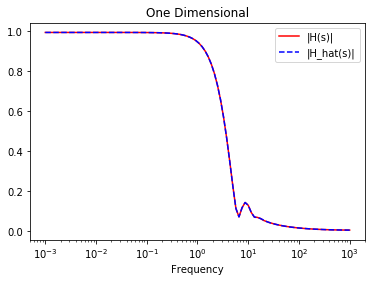

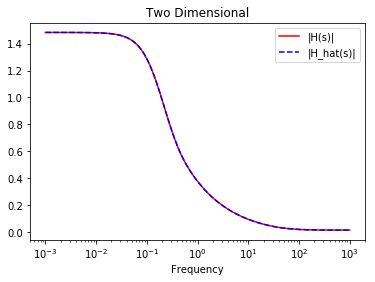

In [70]:
def get_transfer_func(vals):
    """
    Inputs:
        vals - Dictionary of matrices A, B, C, D, and E
        
    Returns a function H(s), where H(s) is equal to the transfer function with
    the inputted matrices.
    """
    def H(s):
        return (np.transpose(vals['C']) @ linalg.solve(s * vals['E'] - vals['A'], vals['B']) + vals['D'])[0][0]
    return H

def compare_transfer_func(vals, hat_vals, title = ""):
    """
    Inputs:
        vals - Dictionary of matrices A, B, C, D, and E
        hat_vals - Dictionary of hat matrices A, B, C, D, and E
        title - (optional) title for the graph
        
    Plots the transfer function of the FOM against the ROM for imaginary 
    frequencies between 1e-3 and 1e3.
    """
    H = get_transfer_func(vals)
    H_hat = get_transfer_func(hat_vals)
    
    H_vals = [abs(H(s * 1j)) for s in np.logspace(-3, 3, 100)]
    H_hat_vals = [abs(H_hat(s * 1j)) for s in np.logspace(-3, 3, 100)]
    
    plt.semilogx(np.logspace(-3, 3, 100), H_vals, color = 'red', label = '|H(s)|')
    plt.semilogx(np.logspace(-3, 3, 100), H_hat_vals, color = 'blue', label = '|H_hat(s)|', linestyle = '--')
    plt.xlabel('Frequency')
    plt.title(title)
    plt.legend()
    plt.show()
    
compare_transfer_func(d1_vals, d1_hat_vals, "One Dimensional")
compare_transfer_func(d2_vals, d2_hat_vals, "Two Dimensional")

Write a function to compare the FOM and the ROM in the time domain given a function $u(t)$. Use this function to illustrate the accuracy of the one dimensional ROM and the two dimensional ROM with various $u(t)$ functions: 

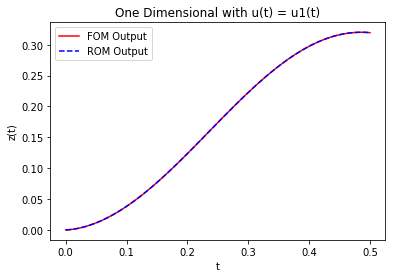

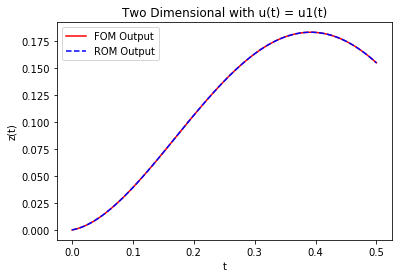

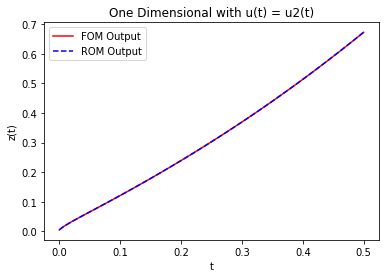

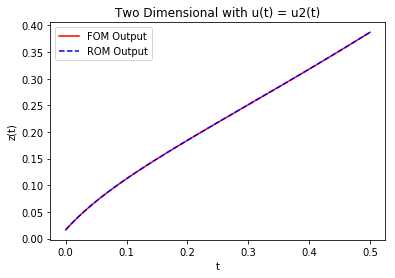

In [71]:
def compare_output(vals, hat_vals, ts, u_func, title = ""):
    """
    Inputs:
        vals - Dictionary of matrices A, B, C, D, and E
        hat_vals - Dictionary of hat matrices A, B, C, D, and E
        ts - Points at which to plot the output function
        u_func - Function for u(t)
        title - (optional) title for the graph
        
    Plots the output of the FOM against the ROM for times in ts.
    """
    fom_size = vals['A'].shape[0]
    rom_size = hat_vals['A'].shape[0]
    
    def func(t, y):
        return (linalg.solve(vals['E'], vals['A'] @ y.reshape((fom_size, 1))) 
                + linalg.solve(vals['E'], vals['B'] * u_func(t))).reshape((fom_size))
    
    def func_hat(t, y):
        return (linalg.solve(hat_vals['E'], hat_vals['A'] @ y.reshape((rom_size, 1))) 
                + linalg.solve(hat_vals['E'], hat_vals['B'] * u_func(t))).reshape((rom_size))
    
    y0 = np.zeros((fom_size))
    y0_hat = np.zeros((rom_size))
    
    fom_y = solve_ivp(func, (0, ts[-1]), y0, t_eval = ts).y
    rom_y = solve_ivp(func_hat, (0, ts[-1]), y0_hat, t_eval = ts).y
    
    us = np.asarray([u_func(t) for t in ts])
    
    fom_output = np.transpose(vals['C']) @ fom_y + vals['D'] * us
    rom_output = np.transpose(hat_vals['C']) @ rom_y + hat_vals['D'] * us
    
    plt.plot(ts, fom_output.reshape((len(ts))), color = 'red', label = 'FOM Output')
    plt.plot(ts, rom_output.reshape((len(ts))), color = 'blue', label = 'ROM Output', linestyle = '--')
    plt.xlabel('t')
    plt.ylabel('z(t)')
    plt.title(title)
    plt.legend()
    plt.show()
    
def u1(t):
    return np.sin(2 * np.pi * t)

def u2(t):
    return np.exp(t)

ts = np.linspace(0, T_INT, nt + 1)

compare_output(d1_vals, d1_hat_vals, ts, u1, "One Dimensional with u(t) = u1(t)")
compare_output(d2_vals, d2_hat_vals, ts, u1, "Two Dimensional with u(t) = u1(t)")

compare_output(d1_vals, d1_hat_vals, ts, u2, "One Dimensional with u(t) = u2(t)")
compare_output(d2_vals, d2_hat_vals, ts, u2, "Two Dimensional with u(t) = u2(t)")